In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

## Oppgave 1


#### 1 a)

For å representere en polymer av en gitt lengde numerisk er det mulig å lagre hele gitteret, inkludert alle null-elementene, som en matrise, hvor sidelengdene er større enn polymeret. Dette er derimot ikke hensiktsmessig ettersom majoriteten av informasjonen lagret er overflødig. For å forenkle dette kan istedet kun selve posisjonen av hver monomer lagres. Polymeren representeres i et 2D kartesisk kordinatsystem, og dermed kan hver monomer posisjon beskrives av en tuppel med kordinatene x og y. Slik kan hele polymeren være representert av en N x 2 matrise.   

#### 1 b)

In [2]:
def create_polymer(N: int) -> np.ndarray:
    """
    Function that returns a list of integers representing the polymer with each element being a touple with the x and y coordinates of the monomer
    :param N: int
    :return: list[int]
    """
    return np.array([(i, 0) for i in range(-N//2, N//2)])

#### 1 c)

Energien til en gitt polymer er avhengig av antall monomerer som vekselsvirker med hverandre. Reglene for denne vekselvirkningen er oppgitt i seksjon 2 av prosjektheftet. I algoritme 1 og 2, som begge er Monte Carlo-metoder, velges tilfeldig en monomer som roteres om. Ettersom rotasjon i endemonomerene ikke endrer formen av polymeret, men heller kun roterer hele polymeret, vil det heller ikke oppstå noen endring av energien i polymeret. Dermed er det ikke hensiktsmessig å inkludere endemonomerene i utvalget den tilfeldige monomeren trekkes fra. 

#### 1 d)

In [3]:
def display_polymer(polymer_list: list[int]) -> None:
    """
    Function that displays the polymer on a black background,
    with a color gradient going from white at the beginning to purple at the end of the polymer.
    :param polymer_list: list[int]
    :return: None
    """
    # Determine the maximum absolute values of x and y to ensure a square grid
    max_x = max(abs(x) for _, x in polymer_list)
    max_y = max(abs(y) for y, _ in polymer_list)
    max_extent = max(max_x, max_y)

    # Define square grid size based on the maximum extent
    grid_size = 2 * max_extent + 1

    X, Y = np.meshgrid(range(-max_extent, max_extent + 1), range(-max_extent, max_extent + 1))
    Z = np.zeros(X.shape)  # Background initialized to 0 (black)

    # Map intensity values for the polymer: 0 (background) remains black,
    # Intensity for polymer starts from a small positive value towards 1
    for i, (y, x) in enumerate(polymer_list):
        # Map intensity from a range that starts slightly above 0 to ensure visibility against black
        intensity = (i / (len(polymer_list) - 1)) * 0.99 + 0.01  # Avoids pure black for the first monomer
        adjusted_x = x + max_extent
        adjusted_y = y + max_extent
        Z[adjusted_y, adjusted_x] = intensity

    # Define a colormap: starts with black (for 0 intensity), transitions from white to purple
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "white", "purple"])

    plt.figure(figsize=(6,6))  # Adjust figure size as needed
    plt.pcolormesh(X, Y, Z, cmap=cmap, shading='auto')  # 'auto' shading for smooth transition
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')  # Optional: Hide axes for a cleaner visualization
    plt.show()


#### 1 e)

We added our own criteria, we make it a requirement that no monomer can share coordinates with another, thus it cannot be on top of itself

In [4]:
def is_intact_polymer_np(polymer_object: np.ndarray, N: int) -> bool:
    """
    Function that checks if the polymer is intact for a NumPy array implementation.
    :param polymer_object: NumPy array of shape (N, 2), representing N monomers' coordinates.
    :param N: int, the expected length of the polymer.
    :return: bool, True if the polymer is intact, False otherwise.
    """
    # Check if the polymer is the right length
    if polymer_object.shape[0] != N:
        return False

    # Ensure all monomer positions are unique
    if np.unique(polymer_object, axis=0).shape[0] != N:
        return False

    # Calculate the differences between consecutive monomers
    diffs = np.diff(polymer_object, axis=0)
    
    # Check for horizontal or vertical adjacency between consecutive monomers
    valid_horizontal = (np.abs(diffs[:, 0]) == 1) & (diffs[:, 1] == 0)
    valid_vertical = (np.abs(diffs[:, 1]) == 1) & (diffs[:, 0] == 0)
    
    if not np.all(valid_horizontal | valid_vertical):
        return False

    return True

#### 1f)

In [5]:
def rotate_polymer_np(polymer: np.ndarray, center: tuple[int, int], counter_clockwise: bool = True) -> np.ndarray:
    """
    Optimized function to rotate the shortest end of the polymer 90 degrees around a specified monomer (center) using NumPy.
    If the center is in the middle, the front half is rotated.
    
    :param polymer: NumPy array of shape (N, 2), representing N monomers.
    :param center: Center point for rotation, as a tuple of (x, y), must be a monomer in the polymer.
    :param counter_clockwise: True for counter-clockwise rotation, False for clockwise.
    :return: NumPy array representing the rotated polymer.
    """
    # Find the index of the center monomer
    center_index = np.where((polymer == center).all(axis=1))[0][0]
    
    # Determine the rotation matrix
    rotation_matrix = np.array([[0, -1], [1, 0]]) if not counter_clockwise else np.array([[0, 1], [-1, 0]])

    # Determine which half to rotate
    if center_index <= len(polymer) // 2:
        # Rotate the first half
        segment_to_rotate = polymer[:center_index + 1]
        remaining_segment = polymer[center_index + 1:]
        translated_segment = segment_to_rotate - center
        rotated_translated_segment = np.dot(translated_segment, rotation_matrix) + center
        return np.vstack((rotated_translated_segment, remaining_segment))
    else:
        # Rotate the second half
        segment_to_rotate = polymer[center_index:]
        remaining_segment = polymer[:center_index]
        translated_segment = segment_to_rotate - center
        rotated_translated_segment = np.dot(translated_segment, rotation_matrix) + center
        return np.vstack((remaining_segment, rotated_translated_segment))


#### 1g)

In [6]:
def algorithm1_optimized(N: int, Ns: int) -> tuple[np.ndarray, int]:
    """
    Numpy optimized algorithm to generate a polymer of length N and rotate it Ns times.
    :param N: int, the length of the polymer.
    :param Ns: int, the number of steps to take.
    :return: tuple, (polymer, number of steps taken).
    """
    counter = 0
    polymer_obj = create_polymer(N)

    for _ in range(Ns):
        random_index = np.random.randint(0, N)
        random_monomer = polymer_obj[random_index]
        counter_clockwise = np.random.choice([True, False])
        rotated_polymer = rotate_polymer_np(polymer_obj, random_monomer, counter_clockwise)
        
        if is_intact_polymer_np(rotated_polymer, N):
            counter += 1
            polymer_obj = rotated_polymer
        else:
            pass
    return polymer_obj, counter

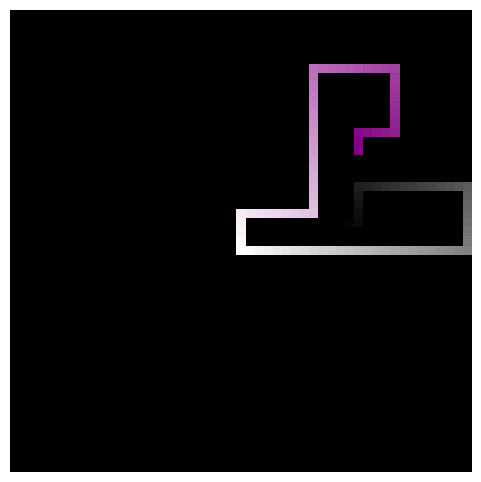

In [7]:
tester_, count = algorithm1_optimized(100, 15)
display_polymer(tester_)

#### 1h)

In [8]:
# implementasjon med numpy array

def polymer_array(N: int) -> list[int]:
   """
    Function that returns a list of integers representing the polymer with each element being a touple with the x and y coordinates of the monomer
    :param N: int
    :return: list[int]
    """
   return [(i, 0) for i in range(-N//2, N//2)]

def is_intact_polymer_array(polymer_object: list[int], N: int) -> bool:
    """
    Function that checks if the polymer is intact
    :param polymer_object: list[int]
    :param N: int
    :return: bool
    """

    # convert from numpy array to list
    polymer_object = list(polymer_object)

    # Check if the polymer is the right length
    if len(polymer_object) != N:
        return False

    # Go through each monomer and check if it has a neighbor
    for i in range(N):
        # Hvis det ikke er den første monomeren, sjekk forrige nabo
        if i > 0 and not (abs(polymer_object[i][0] - polymer_object[i-1][0]) == 1 and polymer_object[i][1] == polymer_object[i-1][1]) and not (polymer_object[i][0] == polymer_object[i-1][0] and abs(polymer_object[i][1] - polymer_object[i-1][1]) == 1):
            return False
        
        # If it is not the last monomer, check next neighbor
        if i < N - 1 and not (abs(polymer_object[i][0] - polymer_object[i+1][0]) == 1 and polymer_object[i][1] == polymer_object[i+1][1]) and not (polymer_object[i][0] == polymer_object[i+1][0] and abs(polymer_object[i][1] - polymer_object[i+1][1]) == 1):
            return False
        
        # Check if the monomer is on top of another monomer\n",
        if polymer_object.count(polymer_object[i]) > 1:
            return False
    return True

def rotate_polymer_array(polymer_object: list[int], xy_val: tuple[int, int], counter_clockwise: bool) -> list[int]:
    """
    Function that rotates the smaller half of the polymer around a point with 90 degrees
    :param polymer_object: list[int]
    :param xy_val: tuple[int, int]
    :param counter_clockwise: bool
    :return: list[int]
    """
    rotated_polymer = []
    rotation_index = polymer_object.index(xy_val)

    # Determine which half to rotate (smaller half or front half if in the middle)
    if rotation_index <= len(polymer_object) // 2:
        # Rotate the front half
        polymer_to_rotate = polymer_object[:rotation_index + 1]
        polymer_remaining = polymer_object[rotation_index + 1:]
    else:
        # Rotate the back half
        polymer_to_rotate = polymer_object[rotation_index:]
        polymer_remaining = polymer_object[:rotation_index]

    # Apply rotation to the chosen half
    for x, y in polymer_to_rotate:
        dx, dy = x - xy_val[0], y - xy_val[1]
        if counter_clockwise:
            new_x, new_y = xy_val[0] - dy, xy_val[1] + dx
        else:
            new_x, new_y = xy_val[0] + dy, xy_val[1] - dx
        rotated_polymer.append((new_x, new_y))

    # Combine the rotated half with the unrotated half
    if rotation_index <= len(polymer_object) // 2:
        rotated_polymer.extend(polymer_remaining)
    else:
        rotated_polymer = polymer_remaining + rotated_polymer

    return rotated_polymer

def algorithm1_array(N: int, Ns: int) -> (list[int], int):
    counter = 0
    polymer_object = polymer_array(N)

    for _ in range(Ns):
        # Choose a random monomer
        random_monomer_index = np.random.randint(0, N)
        random_monomer = polymer_object[random_monomer_index]

        # Randomly choose rotation direction
        rotate_clockwise = np.random.choice([True, False])

        # Rotate the polymer
        rotated_polymer = rotate_polymer_array(polymer_object, random_monomer, not rotate_clockwise)

        # Check if the rotated polymer is intact
        if is_intact_polymer_array(rotated_polymer, N):
            counter += 1
            polymer_object = rotated_polymer

    return polymer_object, counter

In [9]:
# check for optimization

# time the algorithm using timeit

%timeit algorithm1_array(100, 1000)
%timeit algorithm1_optimized(100, 1000)

106 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
49.1 ms ± 92 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Her ser vi at å bruke Numpy arrays og optimalisere rundt linæralgebra for rotasjon gir en betydelig ytelseøkning ovenfor Python array.

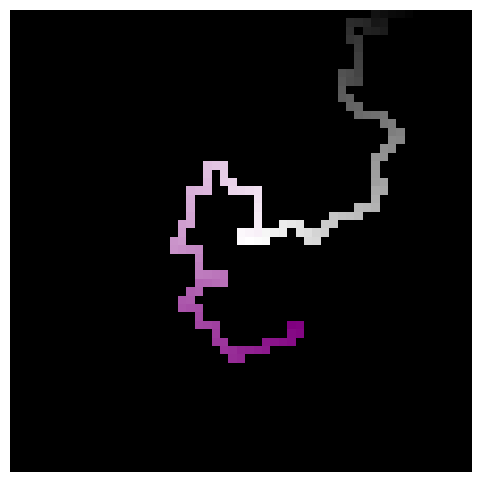

In [10]:
poly_obj, _ = algorithm1_array(150, 1000)
display_polymer(poly_obj)

#### 1j)

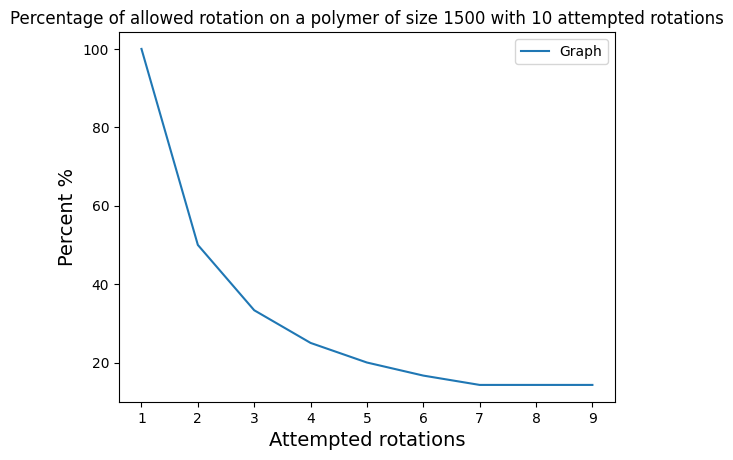

In [11]:
def plot_prosent(N: int, N_s: int) -> None:
    """
    plots the percentage of rotations based on attempted rotations
    """
    x_arr = []
    y_arr = []
    for i in range(1, N_s):
        _, count = algorithm1_array(N, i)
        x_arr.append(i)
        y_arr.append(N_s*10/(count))
    plt.plot(x_arr,y_arr, label = "Graph")
    plt.title(f"Percentage of allowed rotation on a polymer of size {N} with {N_s} attempted rotations")
    plt.ylabel("Percent %", fontsize = 14)
    plt.xlabel("Attempted rotations", fontsize = 14)
    plt.legend()
    plt.show()
plot_prosent(1500,10)



In [12]:

def create_V_matrix(N: int, value: float) -> list[int]:
    """
    Function creates N x N matrix with 0 across, over and under the diagonal
    :param N: int
    """
    # Create an N x N matrix with 0
    matrix = 0 * np.ones((N, N), dtype=int) 

    #sets upper triangle in V matrix to -1
    matrix[np.triu_indices(N, k=2)] = value  

    #sets lower triangle in V matrix to -1
    matrix[np.tril_indices(N, k=-2)] = value  

    return matrix


# def Energy(V_matrix: list[int], polymer: list[int]) -> int:
    
#     for i in list:
#         if ((i+[1,0] in list) or (i+[-1,0] in list) or (i+[0,1] in list) or (i[0,-1] in list)) and not list.index(i) = 1+

In [13]:
def calculate_polymer_energy(polymer, V):
    """
    Beregner energien til en polymer basert på en liste av monomerposisjoner og en vekselvirkningsmatrise V.

    :param polymer: List av tuples som representerer posisjonene til monomerene i polymeren.
    :param V: Numpy matrise som representerer styrken av vekselvirkningene mellom monomerene.
    :return: Energien til polymeren.
    """
    N = len(polymer)  # Antall monomerer i polymeren
    E = 0  # Initialiserer energien

    # Gå gjennom alle par av monomerer for å beregne energibidraget
    for m in range(N):
        for n in range(N):
            if n != m and n != m+1 and n != m-1:  # Sjekker at n er en gyldig nabo
                if is_nearest_neighbor(polymer[m], polymer[n]):
                    E += V[m, n]

    # Normaliser energien siden alle vekselvirkninger telles to ganger
    E = E / 2
    return E

def is_nearest_neighbor(monomer1, monomer2):
    """
    Sjekker om to monomerer er nærmeste naboer i et kvadratisk gitter.

    :param monomer1: Tuple som representerer posisjonen til det første monomeret.
    :param monomer2: Tuple som representerer posisjonen til det andre monomeret.
    :return: True hvis de er nærmeste naboer, ellers False.
    """
    # Beregner avstanden mellom monomerene
    dx = abs(monomer1[0] - monomer2[0])
    dy = abs(monomer1[1] - monomer2[1])

    # Sjekker om avstanden tilsvarer nærmeste naboer
    return (dx == 1 and dy == 0) or (dx == 0 and dy == 1)

In [14]:
# testing energy

polymer_test, _ = algorithm1_array(15, 4)
V = create_V_matrix(15, -1)
print(calculate_polymer_energy(polymer_test, V))

# testing energy
polymer_test, _ = algorithm1_array(15, 1000)
V = create_V_matrix(15, -1)
print(calculate_polymer_energy(polymer_test, V))

0.0
-3.0


## Oppgave 2: Monte Carlo-simuleringer

#### 2 a)

In [15]:

def monte_carlo_sim(polymer: list[int], Ns: int, V: list[int], T: int) -> (list[int], list[int]):
    E_array = np.zeros(Ns, dtype=float)
    polymer1 = [tuple(row) for row in polymer]

    E = calculate_polymer_energy(V, polymer1)
    print(E)
    i = 1
    
    while i < Ns:
        random_monomer_index = np.random.randint(1, len(polymer))
        random_monomer = polymer[random_monomer_index]
        counter_clockwise = np.random.choice([True, False])

        rotated_polymer = rotate_polymer_np(polymer.tolist(), random_monomer, counter_clockwise)

        if is_intact_polymer_np(rotated_polymer, len(polymer)):
            rotated_polymer1 = [tuple(row) for row in rotated_polymer]
            i += 1
            Enew = calculate_polymer_energy(V, rotated_polymer1)

            if Enew < E or np.random.rand() < np.exp(-(1/((1.38*10**(-23))*T)) * (Enew - E)):
                polymer = rotated_polymer
                E = Enew

            E_array[i-1] = E

    return polymer, E_array, rotated_polymer

In [16]:
def algorithm2(polymer_array: np.ndarray, Ns: int, interaction_matrix: np.ndarray, temperature: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Performs a Monte Carlo simulation using the Metropolis algorithm for a polymer.
    
    :param polymer_array: Initial position of the polymer as a NumPy array of shape (N, 2).
    :param Ns: Number of valid rotation attempts.
    :param interaction_matrix: Numpy matrix representing interaction strengths between monomers.
    :param temperature: Dimensionless temperature of the system.
    :return: Tuple consisting of the updated polymer array and energy array.
    """
    N = polymer_array.shape[0]
    energy_array = np.zeros(Ns)
    current_energy = calculate_polymer_energy(polymer_array, interaction_matrix)
    boltzmann_constant = 1.38e-23  # Boltzmann constant in J/K
    beta = 1 / (temperature * boltzmann_constant)  # Inverse temperature, assuming kB = 1 for simplicity
    i = 0

    while i < Ns:
        random_monomer_index = np.random.randint(N)
        rotate_clockwise = np.random.choice([True, False])
        rotated_polymer_array = rotate_polymer_np(np.copy(polymer_array), polymer_array[random_monomer_index], not rotate_clockwise)

        if is_intact_polymer_np(rotated_polymer_array, N):
            new_energy = calculate_polymer_energy(rotated_polymer_array, interaction_matrix)
            delta_energy = new_energy - current_energy
            if delta_energy < 0 or np.random.rand() < np.exp(-beta * delta_energy):
                polymer_array = rotated_polymer_array
                current_energy = new_energy
                
        energy_array[i] = current_energy
        i += 1  # Increment i after each valid rotation attempt

    return polymer_array, energy_array


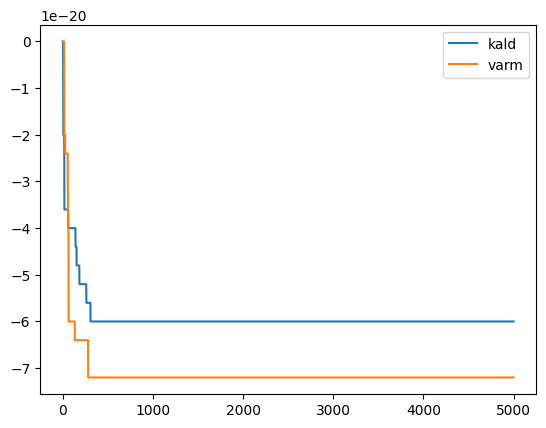

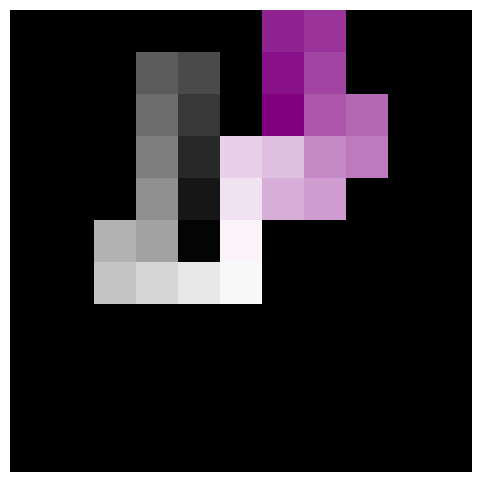

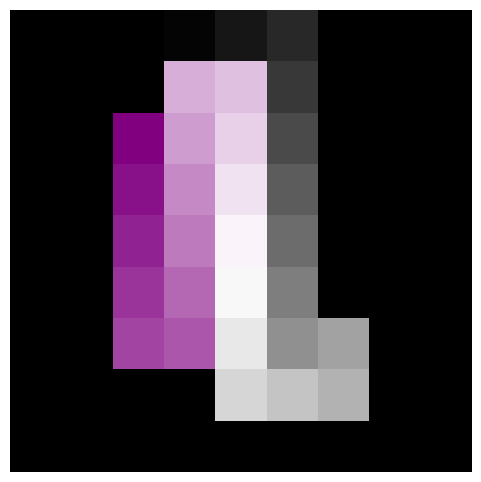

In [18]:
N_s = 5000
polymer_30 = create_polymer(30)
V_matrix = create_V_matrix(30, -1)
polymer_array_c, energy_array_k = algorithm2(polymer_30, N_s, V_matrix, 75)
polymer_array_h, energy_array_v = algorithm2(polymer_30, N_s, V_matrix,300)

plt.plot(np.linspace(0,N_s,N_s),energy_array_k*4.0e-21, label = "kald")
plt.plot(np.linspace(0,N_s,N_s),energy_array_v*4.0e-21, label = "varm")
plt.legend()
plt.show()

display_polymer(polymer_array_c)
display_polymer(polymer_array_h)